### Introduction
In this unit and the next one, we show an example of time series data and showcase the application of machine learning models for such data. In particular, we highlight some of the issues which are special to time series data and one should be mindful of them during the analysis and modeling of such data. Note that our objective is not to do a thorough analysis of time-series data but just to showcase how some of the machine learning models that you learned in this course can be applied to them. Therefore, we will skip most of the Explanatory Data Analysis (EDA), which nevertheless is one of the main pillars of every machine learning project, in order to focus on our main goal.

We use the data from the Global Energy Forecasting Competition and develop a regression problem to predict the one hour ahead electric load based on the hourly electric load and temperature data. Here is the outline of the steps we go through in this unit and we leave the next unit for developing the models:

* Loading the data
* Preliminary EDA
* Creating time features
* Creating lags
* Splitting the sample

Let’s start by loading the data from the c4_energy_data.csv file provided in the resource tab.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("c4_energy_data.csv", index_col=0, parse_dates=True)
print(df.shape)

(8760, 2)


In [2]:
df.head()

,load,temp
timestamp,,
2014-01-01 00:00:00,3295.0,-12.592593
2014-01-01 01:00:00,3173.0,-11.851852
2014-01-01 02:00:00,3085.0,-12.777778
2014-01-01 03:00:00,3053.0,-12.777778
2014-01-01 04:00:00,3077.0,-13.333333


We see that the data has a timestamp index with one-hour increments. The load shows the electric loads in Megawatt and the temp shows the temperatures in Celsius. There is a total of 8760 rows of data which as we later show in this unit is the number of hours from 2014-01-01 00:00:00 to 2014-12-31 23:00:00. The data types as shown below are float and there is no null value in the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2014-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    8760 non-null   float64
 1   temp    8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


It is through the EDA that we learn about the data and decide about the data preprocessing strategies and machine learning modeling technique. Here for brevity, we only show a quick tour of the data before jumping to the modeling part in the next unit.

### Preliminary Explanatory Data Analysis
During the EDA one should explore the data in several ways. In particular, one should inspect (1) each individual feature, (2) the relation between the features, (3) the relation between the features and the target and finally investigate (4) how the interactions of two features can affect the target. However, in time-series data the time dimension has a centric role in the modeling and therefore one should expand the EDA and explore the dynamics of the features and the target over time (trends and cycles). Also, one should check how the target is correlated with its own values in the past (temporal dependencies). Finally, one should be mindful of the changes in the distribution of the data over time (stationarity). In the following, we do not cover all these steps and provide only a preliminary EDA and data preprocessing.

To check if there is any missing hour in the sample we can generate date-time indexes and see if the length of these indexes is the same as the length of our data.

In [4]:
# generate date-time index with hourly frequency
datetime_idx = pd.date_range(min(df.index), max(df.index), freq="H")

print(datetime_idx.shape)

(8760,)


Since the length of the datetime_idx is the same as the length of our data we are sure that there is a data point available for each hour in the sample. But it is still likely that the hours are recorded irregularly. For instance, the time between two values is half an hour instead one hour. To check for this possibility we can have a look at unique hours.



In [5]:
df.index.hour.unique()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='timestamp')

The result shows that values are registered regularly at each hour. Note that there can duplicated values in the data meaning that the temperature or the load don’t change from one hour to the next. You can check this using the duplicated() function.

To get a sense of the distribution of the data we can quickly check the descriptive statistics and the histograms.

In [6]:
# descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
load,8760.0,3329.719806,547.932788,2107.00000,2911.000000,3387.000000,3721.250000,5036.00000
temp,8760.0,8.080395,11.160144,-25.37037,-0.185185,8.888889,17.037037,30.37037


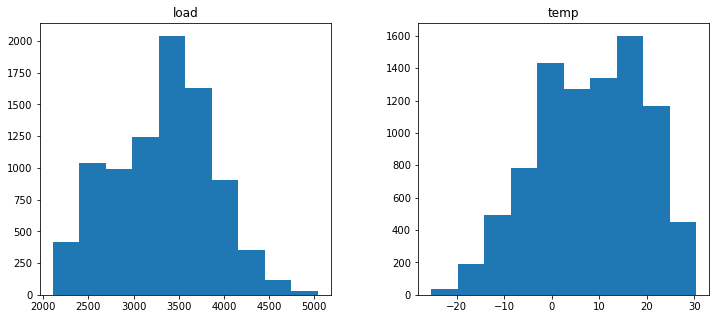

In [7]:
# plot histograms
df[["load", "temp"]].hist(figsize=(12, 5), bins=10, grid=False)
plt.show()

According to the descriptive statistics and the histograms the data contain no extreme observation and the distributions look fairly symmetric.

To get a quick sense of the trends and cycles in the data we can plot them against time.

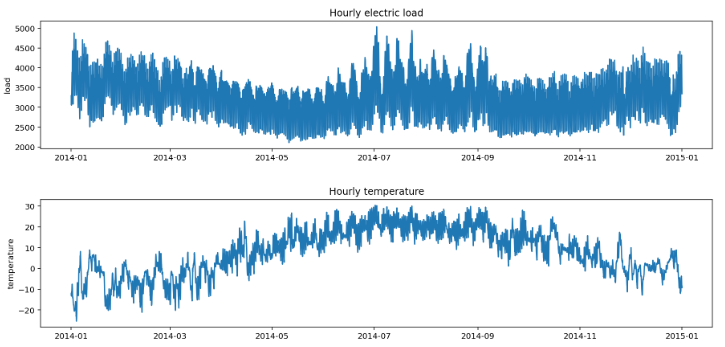

In [8]:
from IPython.display import Image
Image(filename="time_plot.png")

As expected, both electric load and temperature time-series show seasonal trends meaning that there are regular repetitions of patterns over time. Therefore, in general, the time could provide a basis for our expectation of the electric load. For instance, the first plot shows that the load is higher at the beginning, middle, and end of the year when the weather is either too cold or too hot. It is also likely that the day of the week and the hour matter for the load demand. So, let’s benefit from the time index of the data and create features that represent the time.



Some time-series processes are not stationary in the sense that their distributions vary over time. One can use statistical tests of stationarity or visually assess this behavior. Differencing and log-transformation are two approaches to fight non-stationarity and to stabilize the mean and variance of the time series processes. The load and temperature data do not show a strong violation of stationarity as the data vary within a certain range and don’t exhibit exploding trends.

In [9]:
# create time features
df["month"] = df.index.month - 1
df["day"] = df.index.day_of_week
df["hour"] = df.index.hour

df.head()

,load,temp,month,day,hour
timestamp,,,,,
2014-01-01 00:00:00,3295.0,-12.592593,0,2,0
2014-01-01 01:00:00,3173.0,-11.851852,0,2,1
2014-01-01 02:00:00,3085.0,-12.777778,0,2,2
2014-01-01 03:00:00,3053.0,-12.777778,0,2,3
2014-01-01 04:00:00,3077.0,-13.333333,0,2,4


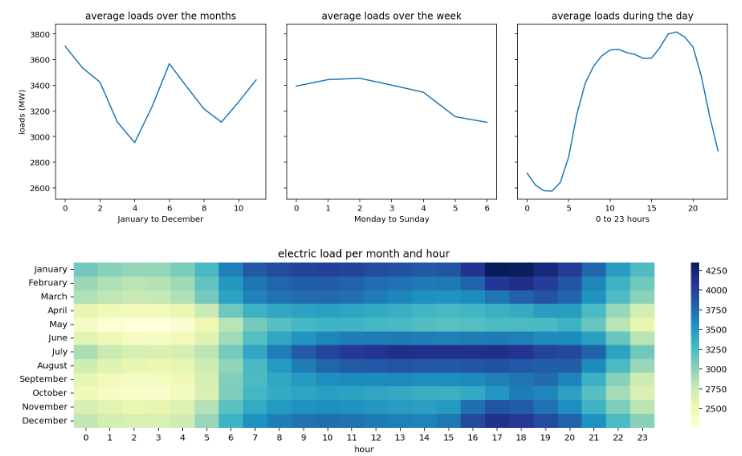

In [10]:
Image(filename="plots.png")

The plots in the first row show that the load demand is higher in January, July and December (compared to other months), during the weekdays (compared to the weekends) and during the daytime (compared to the nights). Therefore, it makes sense to keep these features and use them in our models. Note that the interactions of time features could also matter for the electric load. The heatmap shows that demand for the electric load during the daytime depends on the month, whereas from 1 am to 5 am the month doesn’t matter much.

Next, we create two features that can play a big role in predicting the load. One simple conjecture is that the past values of the load and temperature can predict load demand. Our data has an hourly frequency and our objective is to predict the load one hour ahead. Therefore, we create lags of the load and temperature.



In [11]:
# 1 hour lags
df["load_lag1"] = df["load"].shift(1)
df["temp_lag1"] = df["temp"].shift(1)

#  dropping the rows with na
df.dropna(how="any", inplace=True)

# we don't need the temp anymore
df.drop(["temp"], axis=1, inplace=True)

df.head()

,load,month,day,hour,load_lag1,temp_lag1
timestamp,,,,,,
2014-01-01 01:00:00,3173.0,0,2,1,3295.0,-12.592593
2014-01-01 02:00:00,3085.0,0,2,2,3173.0,-11.851852
2014-01-01 03:00:00,3053.0,0,2,3,3085.0,-12.777778
2014-01-01 04:00:00,3077.0,0,2,4,3053.0,-12.777778
2014-01-01 05:00:00,3171.0,0,2,5,3077.0,-13.333333


Now let’s visualize the relationship between the lagged temperature and load that we just created and the current load values.



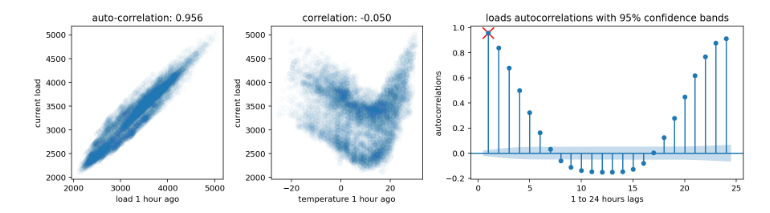

In [12]:
Image(filename="lags.png")

From the plots, it seems that the load one hour in the past is a potential predictor of the load. Also, the nature of the relation between the temperature and the load is not linear and finally, the auto-correlation plot on the right shows that the load is auto-correlated with many lagged loads.



Using only the 1st lag is a simple strategy that doesn’t lead necessarily to the best prediction. The EDA can help to gain insight into the temporal dependencies in the data. In particular, one should motivate the choice of lagged features based on auto-correlations in the data, and then decide how many lags are needed. One can decide about the number of lags based on certain statistical tests, or even tune it as a parameter using the validation set.

### Sample split
We use the last month of the sample, i.e. December, for testing and the rest of the data, that is January to November for training and validations. For simplicity, we don’t use the rolling windows or expanding windows strategies for splitting time series data as discussed in the previous course. The following plot shows how the training, validation and test sets are placed ahead of each other over time.



In [13]:
# Split into train/test sets
train = df.loc["2014-01-01":"2014-10-30"]  # 10 months
valid = df.loc["2014-11-01":"2014-11-30"]  # 1 month
test = df.loc["2014-12-01":"2014-12-31"]  # 1 month

print("Train:", train.shape)
print("Validation: ", valid.shape)
print("Test: ", test.shape)


Train: (7271, 6)
Validation:  (720, 6)
Test:  (744, 6)


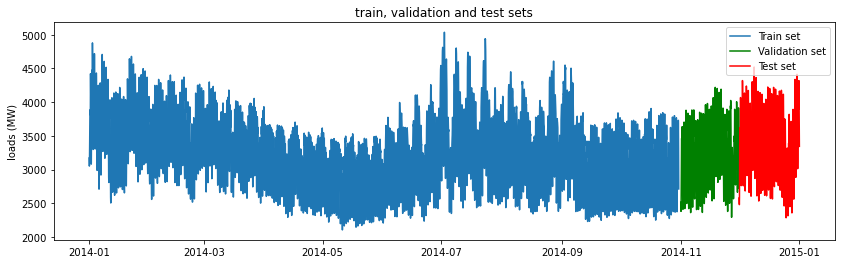

In [14]:
# Plot training and test sets
fig = plt.figure(figsize=(14, 4))
plt.plot(train.load, label="Train set")
plt.plot(valid.load, label="Validation set", color="g")
plt.plot(test.load, label="Test set", color="r")

plt.title("train, validation and test sets")
plt.ylabel("loads (MW)")
plt.legend()
plt.show()

However, since we intend to perform grid search cross-validation, we don’t use a fixed validation set as shown above (in green). We rather let the validation set iterate between January to November. To do this we use the TimeSeriesSplit cross-validator object as shown in the following example with 5 splits.

In [15]:
#  load the library
from sklearn.model_selection import TimeSeriesSplit

# Split data into train/test sets
train = df.loc["2014-01-01":"2014-11-30"]  # 11 months
test = df.loc["2014-12-01":"2014-12-31"]  # 1 month

# Split train set into train/validation sets
cv = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1)  #  1 month of validation set

Note that here the test_size in the TimeSeriesSplit object refers to the size of the validation data, which we set to 1 month.

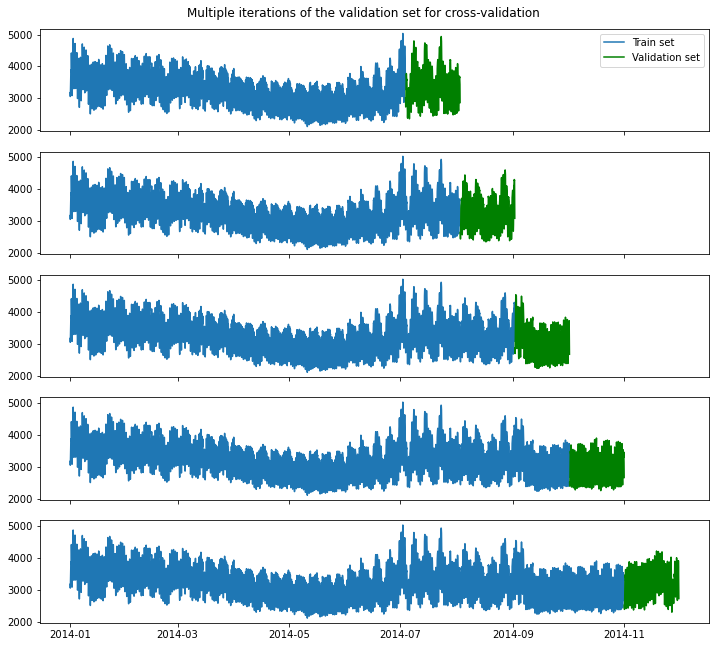

In [16]:
# Plot iterations of the training and validation sets
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True, sharey=True)
plt.suptitle("Multiple iterations of the validation set for cross-validation")

for (i, (tr, val)), ax in zip(enumerate(cv.split(train.load)), axes.ravel()):

    # Plot training and validation sets
    ax.plot(train["load"][tr], label="Train set")
    ax.plot(train["load"][val], label="Validation set", color="g")

axes[0].legend()
plt.subplots_adjust(top=0.95)
plt.show()

Unlike the standard cross-validation objects (e.g. KFold) the TimeSeriesSplit makes sure that the validation sets come always after the training set.

In the next unit, we show how to use this cross-validator object for the grid search. For now, let’s save the train and test sets for the next unit where we use them to train and test two machine learning models.

In [17]:
# save the data into csv files
train.to_csv("c4_ts_train.csv")
test.to_csv("c4_ts_test.csv")

### Machine learning with time series data: Modeling
#### Building machine learning models

From the previous unit we have already the insight that the features are related to the target in both linear and non-linear ways and also that the interactions between features can lead to changes in the target. Therefore, following this motivation we build linear and non-linear models to predict the one-hour-ahead electric load.

In this unit we choose simple linear regression and also random forest as the machine learning models, and for each model we decide about the appropriate preprocessing of the features. Furthermore, we choose the mean absolute error as the metrics and the median as the baseline. Here is the outline of the steps we go through in this unit:

* Loading the train/test sets
* Creating a dummy baseline
* Performing the data preprocessing
* Creating the parameter grid and the pipeline
* Creating the cross-validation object: splitting the training set into training and validation sets
* Fitting and prediction
* Post-modeling analysis

Let’s start by loading the necessary libraries and the training and test data that we saved in the previous unit.



In [18]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn import set_config

%matplotlib inline
# Load the data
train = pd.read_csv("c4_ts_train.csv", index_col=0, parse_dates=True)
test = pd.read_csv("c4_ts_test.csv", index_col=0, parse_dates=True)

print("Train:", train.shape)
print("Test: ", test.shape)


Train: (8015, 6)
Test:  (744, 6)


In [19]:
# specifying features and the target for train/test sets
X_tr = train.drop(["load"], axis=1)
y_tr = train["load"]
X_te = test.drop(["load"], axis=1)
y_te = test["load"]

X_tr.head()

,month,day,hour,load_lag1,temp_lag1
timestamp,,,,,
2014-01-01 01:00:00,0,2,1,3295.0,-12.592593
2014-01-01 02:00:00,0,2,2,3173.0,-11.851852
2014-01-01 03:00:00,0,2,3,3085.0,-12.777778
2014-01-01 04:00:00,0,2,4,3053.0,-12.777778
2014-01-01 05:00:00,0,2,5,3077.0,-13.333333


Remember that the training set covers the data from January to November whereas the test set contains only the December data.

#### Baseline
The idea behind having a baseline is to see if we can rely on the past information as a proxy for what comes in the future without using any machine learning techniques. Here we use the median of the loads in the training set and find it to be 455 Megawatt away from the electric load in the test set which is not bad but still, it is worth seeing if we can get more accurate predictions.

In [20]:
# baseline
baseline = MAE(y_te, np.median(y_tr) * np.ones(len(y_te)))
print("baseline MAE: {:.2f}".format(baseline))

baseline MAE: 455.40


#### Linear regression with regularization
Next we develop a ridge regression model which requires one-hot encoding of the categorical features and standardization of the numerical features. We use OneHotEncoder to handle the month, day and hour and let the rest i.e. the lags of the load and temperature to be scaled using the StandardScaler(). Alternatively, we could define a separate transformer for numerical features and apply it using the ColumnTransformer estimator.



In [21]:
# One-hot encoding for categorical columns
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Applying the transformers
preprocessor = ColumnTransformer(
    [("cat", cat_transformer, ["month", "day", "hour"])], remainder=StandardScaler()
)

Note that an alternative method for encoding cyclical features such as month, day and hour is to do cyclical encoding using the sine and cosine functions.

We are now ready to put the preprocessor of the data in a pipeline along with the ridge regression model. We use the TimeSeriesSplit from the previous unit to create a cross-validator object. We set the number of splits to be 5 and the validation set to be 1 month i.e. 24 hours multiplied by 30 days.

Unlike the K-Folds cross-validator where we can shuffle the data before splitting them, we do not shuffle the time series data because the samples typically don’t satisfy the criteria of independent and identically distributed random samples.

We use the pipeline as the estimator, a grid of the hyperparameter α, and the cross-validator object to do a grid search using the GridSearchCV object.

In [22]:
# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("ridge", Ridge())])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1)  # 1 month validation

# Create grid for alpha
grid = {"ridge__alpha": np.logspace(-4, 4, num=20)}

# Create the grid search object
model_ridge = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=0,
)

Note that for the scoring function we use neg_mean_absolute_error to evaluate the performance of the cross-validated model on the validation set. neg_mean_absolute_error is a scoring function for regression problems and will be maximized for each value of hyperparameter in the grid. Now we have all the objects ready to fit the estimator on the training set and predict on the test set.



In [23]:
# Fit on the training set
model_ridge.fit(X_tr, y_tr)

# Evaluate on the test set
y_pred_ridge = model_ridge.predict(X_te)

ridge_mae = MAE(y_te, y_pred_ridge)
print("ridge regression MAE: {:.2f}".format(ridge_mae))

ridge regression MAE: 52.49


The resulting error is about 9 times smaller than the baseline which is a huge gain. Below we can see the pipeline steps in a diagram.



In [24]:
# set config to diagram for visualizing the pipelines/composite estimators
set_config(display="diagram")

# Let's visualize the best estimator from grid search.
model_ridge.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day', 'hour'])])),
                ('ridge', Ridge(alpha=1.623776739188721))])

In [25]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model_ridge.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_ridge__alpha",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_ridge__alpha
10,-56.497648,10.829177,-49.139631,0.995847,1.623777
9,-56.513229,10.872032,-49.142823,0.995649,0.615848
8,-56.521073,10.887943,-49.145516,0.995283,0.233572
7,-56.524325,10.893912,-49.146727,0.995113,0.088587
6,-56.525571,10.896179,-49.147229,0.995025,0.033598


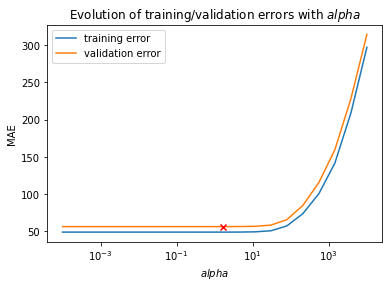

In [26]:
# Plot test curve
plt.semilogx(
    cv_results["param_ridge__alpha"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.semilogx(
    cv_results["param_ridge__alpha"],
    -cv_results["mean_test_score"],
    label="validation error",
)

plt.scatter(
    model_ridge.best_params_.values(),
    -1 * model_ridge.best_score_,
    marker="x",
    c="red",
    zorder=10,
)
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with $alpha$")

plt.legend()
plt.show()

The results of the cross-validation are returned in the form of a dataframe as well as a plot. The result indicates a mild sign of overfitting as the validation error is about 10% higher than the training error.

### Random forest
Next we develop a random forest to predict the one-hour-ahead load. We follow the steps as in the case of the linear model but there are two main differences. firstly, we don’t need to scale the numerical features and therefore use remainder="passthrough" in the ColumnTransformer. Secondly, we tune the hyperparameter n_estimators.

In [27]:
# Applying the transformers without scaling
preprocessor = ColumnTransformer(
    [("cat", cat_transformer, ["month", "day", "hour"])], remainder="passthrough"
)

# Create pipeline
pipe_rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rf", RandomForestRegressor(min_samples_split=20)),
    ]
)

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=3, test_size=24 * 30 * 1)  # 1 month validation

# Create grid for alpha
grid = {"rf__n_estimators": np.arange(2, 151, 5)}

# Create the grid search object
model_rf = GridSearchCV(
    pipe_rf,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=0,
)

In [28]:
# Fit on the training set
model_rf.fit(X_tr, y_tr)

# Evaluate on the test set
y_pred_rf = model_rf.predict(X_te)

rf_mae = MAE(y_te, y_pred_rf)
print("random forest regression MAE: {:.2f}".format(rf_mae))

random forest regression MAE: 43.36


In [29]:
# Lets visualize the best estimator from grid search.
model_rf.best_estimator_


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day', 'hour'])])),
                ('rf',
                 RandomForestRegressor(min_samples_split=20, n_estimators=82))])

In [30]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model_rf.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_rf__n_estimators",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_rf__n_estimators
16,-44.352557,2.458804,-31.092594,0.683707,82
10,-44.433471,2.352053,-31.227148,0.789134,52
20,-44.587187,1.999964,-31.062667,0.797106,102
13,-44.597466,2.254733,-31.162644,0.789582,67
26,-44.601068,2.058778,-31.194505,0.723746,132


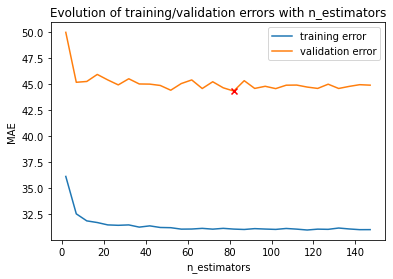

In [31]:
# Plot test curve
plt.plot(
    cv_results["param_rf__n_estimators"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.plot(
    cv_results["param_rf__n_estimators"],
    -cv_results["mean_test_score"],
    label="validation error",
)

plt.scatter(
    model_rf.best_params_.values(),
    -1 * model_rf.best_score_,
    marker="x",
    c="red",
    zorder=10,
)
plt.xlabel("n_estimators")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with n_estimators")
plt.legend()
plt.show()

The performance on the validation set improves by increasing the number of estimators but it flattens halfway.

#### Comparing performances
The two models show huge reductions in the mean absolute error compared to the baseline when predicting on the test set according to the following bar chart. In the other plot we show the predicted load with the two models along with the observed loads for a single day in the test set. The plot shows that from 1am to around 5am the random forest outperforms the ridge regression, whereas from 6am to around 3pm the ridge regression shows more accurate predictions. Finally, from around 4pm to midnight both models fails to closely predict the one-hour-ahead loads.

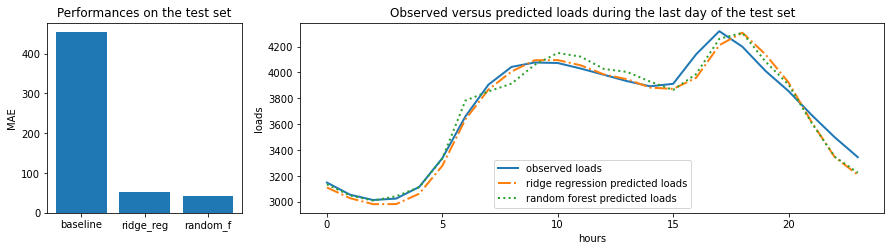

In [32]:
fig, axes = plt.subplots(
    1, 2, figsize=(15, 3.5), gridspec_kw={"wspace": 0.15, "width_ratios": [1, 3]}
)

axes[0].bar(np.arange(3), [baseline, ridge_mae, rf_mae])
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(("baseline", "ridge_reg", "random_f"))
axes[0].set_ylabel("MAE")
axes[0].set_title("Performances on the test set")

axes[1].plot(y_te.values[-1 * 24 :], lw=2, label="observed loads")
axes[1].plot(
    y_pred_ridge[-1 * 24 :], ls="-.", lw=2, label="ridge regression predicted loads"
)
axes[1].plot(y_pred_rf[-1 * 24 :], ls=":", lw=2, label="random forest predicted loads")

axes[1].set_title("Observed versus predicted loads during the last day of the test set")
axes[1].set_xlabel("hours")
axes[1].set_ylabel("loads")
axes[1].legend()

plt.show()

As you could guess from the previous unit the feature load_lag1 plays the main role in predicting the target. This is a common property of some time series data and is called autoregression meaning that the target variable depends linearly on its own previous values (remember the 0.95 auto-correlation from the previous unit). In time series analysis, a model where the target load depends on load_lag1 and random noise is called an autoregressive order one or briefly AR(1).

Note that you can even consider the load from the previous hour as a prediction for the current load without any modeling. In other words, the lagged loads load_lag1 can act as a (smart) baseline before building any model. Below, you can see how the performance of such baseline can be compared with the other baseline and models.|

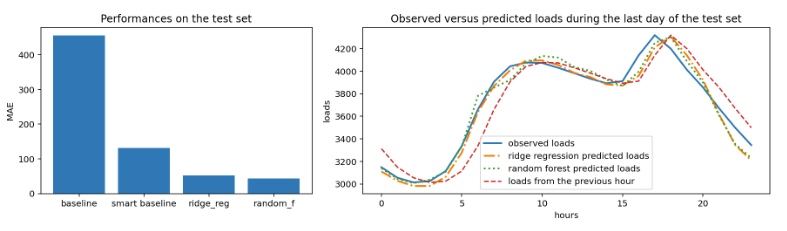

In [33]:
from IPython.display import Image
Image(filename="compare.png")

The plots show that the two models don’t remarkably outperform the smart baseline as they did to the first baseline. This is a common situation for time series data with high auto-correlation which may put machine learning models in time series analysis in difficult position to be justified and deployed. In particular, in time series data without seasonalities it may be very difficult to beat the smart baseline.

Note that our objective was to build models that can predict the electric loads one hour ahead. But you can change this prediction horizon to be more than only one hour. Deciding about the prediction horizon depends on the domain, the problem that is intended to be solved, and the policy implication of the machine learning project. For instance, in macroeconomics it is desirable for policymakers to have an idea about the dynamics of the economy several years in advance. However, for a trader in the financial markets predicting the dynamics of an index even a few seconds in advance is valuable.

##### Summary

Here is a quick summary of what we did in this unit:

* We framed a regression problem and used the ridge regression and the random forest regressor to address it.
* We showed different preprocessing steps for each model in the pipeline.
* We showed how to perform cross-validation for time series data.
* We trained the data on the training sets, tuned the hyperparameters on the validated sets and predicted on the test set.